# Tansfer learning testing:

In [1]:
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import time

In [2]:
# Cargar el conjunto de datos
def load_dataset(data_dir, class_names, target_size=(96, 96)):
    images, labels = [], []
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img) / 127.5 - 1.0  # Normalizar a [-1, 1]
            images.append(img_array)
            labels.append(label)
    print(f'Loaded {len(images)} images with {len(labels)} labels')
    return np.array(images), np.array(labels)

# Descargar y preparar el conjunto de entrenamiento
train_url = "https://storage.googleapis.com/download.tensorflow.org/data/rps.zip"
train_path = get_file(origin=train_url, extract=True)
train_base_dir = os.path.join(os.path.dirname(train_path), 'rps')
class_names = ['rock', 'paper', 'scissors']
x_train, y_train = load_dataset(train_base_dir, class_names)

# Descargar y preparar el conjunto de prueba
test_url = "https://storage.googleapis.com/learning-datasets/rps-test-set.zip"
test_path = get_file(origin=test_url, extract=True)
test_base_dir = os.path.join(os.path.dirname(test_path), 'rps-test-set')
x_test, y_test = load_dataset(test_base_dir, class_names)

Loaded 2520 images with 2520 labels
Loaded 372 images with 372 labels


### Entrenar el modelo MobileNetV3Small desde cero:

In [3]:
def train_from_scratch(mini=True):
    # Cargar el modelo sin pesos preentrenados
    base_model = MobileNetV3Small(weights=None, 
                                  include_top=False, 
                                  input_shape=(96, 96, 3), 
                                  include_preprocessing=False, 
                                  minimalistic=mini)

    # Añadir capas superiores personalizadas
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),  # Capa densa personalizada
        Dense(3, activation='softmax')  # 3 clases: Rock, Paper, Scissors
    ])

    # Compilar el modelo
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.build(input_shape=(None, 96, 96, 3))
    model.summary()

    # Configurar parada anticipada
    early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

    # Entrenar el modelo
    start_time = time.time()
    history = model.fit(
        x_train, y_train,
        validation_split=0.2,
        batch_size=32,
        epochs=5,
        callbacks=[early_stopping]
    )
    training_time = time.time() - start_time

    # Evaluar el modelo en el conjunto de prueba
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"Pérdida: {loss}, Exactitud: {accuracy}")

    # Predicciones
    y_pred = np.argmax(model.predict(x_test), axis=-1)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Verdadera')
    plt.show()

    return model.count_params(), len(history.epoch), training_time, accuracy

### Extraer características del modelo preentrenado:

In [4]:
def extract_features(mini=True):
    # Cargar el modelo preentrenado sin la capa superior
    base_model = MobileNetV3Small(weights='imagenet', 
                                  include_top=False, 
                                  input_shape=(96, 96, 3), 
                                  include_preprocessing=False, 
                                  minimalistic=mini)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'), # Capa densa personalizada
        Dense(3, activation='softmax') # 3 clases: Rock, Paper, Scissors
    ])

    # Compilar el modelo
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.build(input_shape=(None, 96, 96, 3))
    model.summary()

    # Configurar parada anticipada
    early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

    # Entrenar el modelo
    start_time = time.time()
    history = model.fit(
        x_train, y_train,
        validation_split=0.2,
        batch_size=32,
        epochs=5,
        callbacks=[early_stopping]
    )
    training_time = time.time() - start_time

    # Evaluar el modelo en el conjunto de prueba
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"Pérdida: {loss}, Exactitud: {accuracy}")

    # Predicciones
    y_pred = np.argmax(model.predict(x_test), axis=-1)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Verdadera')
    plt.show()

    return model.count_params(), len(history.epoch), training_time, accuracy

### Fine-tuning del modelo:

In [5]:
def fine_tune_model(num_unfrozen_layers, last_layers=True, mini=True):
    # Cargar el modelo preentrenado sin la capa superior
    base_model = MobileNetV3Small(weights='imagenet', 
                                  include_top=False, 
                                  input_shape=(96, 96, 3), 
                                  include_preprocessing=False, 
                                  minimalistic=mini)
    
    # Congelar el modelo base completo
    base_model.trainable = False

    if last_layers:
        # Descongelar las últimas capas
        for layer in base_model.layers[-num_unfrozen_layers:]:
            layer.trainable = True
    else:
        # Descongelar las primeras capas
        for layer in base_model.layers[:num_unfrozen_layers]:
            layer.trainable = True

    # Añadir capas superiores personalizadas
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),  # Capa densa personalizada
        Dense(3, activation='softmax')  # 3 clases: Rock, Paper, Scissors
    ])

    # Compilar el modelo
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.build(input_shape=(None, 96, 96, 3))
    model.summary()

    # Configurar parada anticipada
    early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

    # Entrenar el modelo
    start_time = time.time()
    history = model.fit(
        x_train, y_train,
        validation_split=0.2,
        batch_size=32,
        epochs=5,
        callbacks=[early_stopping]
    )
    training_time = time.time() - start_time

    # Evaluar el modelo en el conjunto de prueba
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"Pérdida: {loss}, Exactitud: {accuracy}")

    # Predicciones
    y_pred = np.argmax(model.predict(x_test), axis=-1)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Verdadera')
    plt.show()

    return model.count_params(), len(history.epoch), training_time, accuracy

### Comparación de los tres métodos de learning transfer:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 3, 3, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               73856     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,013,363
Trainable params: 74,243
Non-trainable params: 939,120
_________________________________________________________________
Epoch 1/5
63/63 [==========================

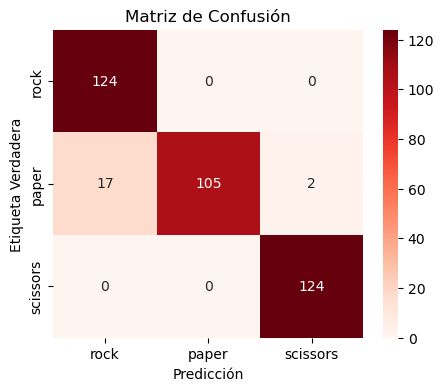

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 3, 3, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               73856     
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,013,363
Trainable params: 74,243
Non-trainable params: 939,120
_________________________________________________________________
Epoch 1/5
63/63 [========================

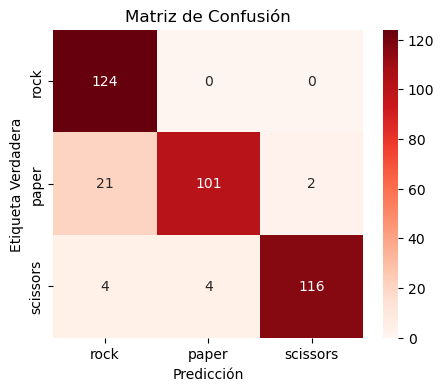

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 3, 3, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               73856     
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,013,363
Trainable params: 1,001,251
Non-trainable params: 12,112
_________________________________________________________________
Epoch 1/5
63/63 [======================

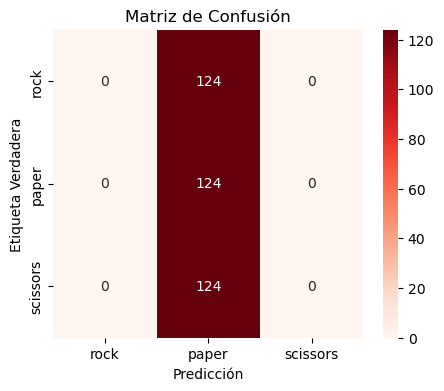

                        Enfoque  Parámetros  Épocas  \
0  Extractor de características     1013363       3   
1                   Ajuste fino     1013363       2   
2      Entrenamiento desde cero     1013363       2   

   Tiempo de entrenamiento (s)  Exactitud en test  
0                    87.547820           0.948925  
1                    57.795434           0.916667  
2                   144.486892           0.333333  


In [6]:
# Obtener datos de los tres enfoques
params_extractor, epochs_extractor, time_extractor, accuracy_extractor = extract_features(False)
params_fine_tune, epochs_fine_tune, time_fine_tune, accuracy_fine_tune = fine_tune_model(30, mini=False) # Configuración aproximadamente óptima
params_scratch, epochs_scratch, time_scratch, accuracy_scratch = train_from_scratch(False)

# Crear la tabla comparativa
data = {
    "Enfoque": ["Extractor de características", "Ajuste fino", "Entrenamiento desde cero"],
    "Parámetros": [params_extractor, params_fine_tune, params_scratch],
    "Épocas": [epochs_extractor, epochs_fine_tune, epochs_scratch],
    "Tiempo de entrenamiento (s)": [time_extractor, time_fine_tune, time_scratch],
    "Exactitud en test": [accuracy_extractor, accuracy_fine_tune, accuracy_scratch]
}

df_comparison = pd.DataFrame(data)
print(df_comparison)